# The Solow model with human capital

Imports and set magics:

In [149]:
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

The following model and definitions should be consistent with Sørensen & Whitta-Jacobsen: “Introducing Advanced Macroeconomics: Growth and Business Cycles”.

I assume the model follows the Coob-Douglas production function. It is defined as:

$Y_{t}=K_{t}^{\alpha}H_{t}^{\varphi}\left(A_{t}L_{t}\right)^{1-\alpha-\varphi},\alpha+\varphi<1,0<\alpha<1,0<\varphi<1$

The total production is thus given as a function of physical- and human capital, the level of technology and labor.

The following two equations describe how physical- and human capital grows over time.

$K_{t+1}=s_{K}Y_{t}+\left(1-\delta\right)K_{t},0<s_{K}<1,0<\delta<1,0<K_{0}$


$H_{t+1}=s_{H}Y_{t}+\left(1-\delta\right)H_{t},0<\delta<1,0<s_{H}<1,0<H_{0}$

Here $\delta$ is the depreciation rate. $s_{H}$ and $s_{K}$ denotes the saving rates

The next two equations shows how the technology and labor grows

$A_{t+1}=\left(1+g\right)A_{t},0<g,0<A_{0}$

$L_{t+1}=\left(1+n\right)L_{t},-1<n,0<L_{0}$

Technology grows with a constant rate of $g$, labor with $n$.


Using the following definitions I can find the models transition equations.

$\tilde{k_{t}}\equiv\frac{k_{t}}{A_{t}L_{t}},\tilde{h_{t}}\equiv\frac{h_{t}}{A_{t}L_{t}},\tilde{y_{t}}\equiv\frac{y_{t}}{A_{t}L_{t}}$


The transition equations are then

$\tilde{k}_{t+1}=\frac{1}{\left(1+n\right)\left(1+g\right)}\left(s_{K}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+\left(1-\delta\right)\tilde{k}_{t}\right)$

$\tilde{h}_{t+1}=\frac{1}{\left(1+n\right)\left(1+g\right)}\left(s_{H}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+\left(1-\delta\right)\tilde{h}_{t}\right)$



## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [127]:
# Define parameters
k = sm.symbols('k')
h = sm.symbols('h')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
phi = sm.symbols('phi')
s_K = sm.symbols('s_K')
s_H = sm.symbols('s_H')
g = sm.symbols('g')
n = sm.symbols('n')
param = [k, h, alpha, delta, phi, s_K, s_H, g, n]

In [128]:
# Call the function
nullcline_k, nullcline_h = mp.nullclines(param)

# Print the results
print("nullcline for k =", nullcline_k)
print("nullcline for h =", nullcline_h)

nullcline for k = [(k**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/phi)]
nullcline for h = [((delta + g*n + g + n)/(k**alpha*s_H))**(1/(phi - 1))]


The two nullclines is found to be:

$\tilde{h_{t}}=\left(\frac{n+g+\delta+ng}{s_{K}}\right)^{\frac{1}{\varphi}}\tilde{k}_{t}^{\frac{1-\alpha}{\varphi}},\Delta\tilde{k}_{t}=0$

$\tilde{h_{t}}=\left(\frac{s_{H}}{n+g+\delta+ng}\right)^{\frac{1}{1-\varphi}}\tilde{k}_{t}^{\frac{\alpha}{1-\varphi}},\Delta\tilde{h}_{t}=0$

The analytical solution for the steady state in the Solow model with human capital is:

$\tilde{k}^{*}=\left(\frac{s_{K}^{1-\varphi}s_{H}^{\varphi}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$

$\tilde{h}^{*}=\left(\frac{s_{K}^{\alpha}s_{H}^{1-\alpha}}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha-\varphi}}$

I could however not figure how to solve two equations with two unknown in sympy.

The steady state squations can be turned into python functions

In [129]:
# Defining SS solutions
kss = sm.Eq(k,((s_K**(1-phi) * s_H**phi) / ((n+g+delta+n*g)))**(1 / (1-alpha-phi)))
hss = sm.Eq(h,((s_K**(alpha) * s_H**(1-alpha)) / ((n+g+delta+n*g)))**(1 / (1-alpha-phi)))

# Turing solutions into Python functions
kss_func = sm.lambdify((s_K,s_H,g,n,delta,phi,alpha),kss)
hss_func = sm.lambdify((s_K,s_H,g,n,delta,phi,alpha),hss)

Now i evaluate the models with parameter vaules of

$s_{K}=0.25,s_{H}=0.13,g=0.02,n=0.01,\delta=0.1,\varphi=\alpha=\frac{1}{3}$


In [138]:
mp.aevaluation(x)

# Call the functions with values of the parameters
print('the steady state for k is',kss_func(0.25,0.13,0.02,0.01,0.1,1/3,1/3))
print('the steady state for h is',hss_func(0.25,0.13,0.02,0.01,0.1,1/3,1/3))

the steady state for k is 3.6812085067995786
the steady state for h is 1.914228423535781


## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

I will now solve the model numerically and compare it with the analytical solution. First i define the parameters, then I solve the model numerically. 

In [ ]:
s_K = 0.25
s_H = 0.13
g = 0.02
n = 0.01
delta = 0.1
phi = 1/3
alpha = 1/3

In [143]:
# Define function to find steady state
def ss_func(x, s_K, s_H, g, n, delta, phi, alpha):
    k, h = x
    eq1 = (s_K*k**alpha*h**phi + (1-delta)*k) / ((1+n)*(1+g)) - k
    eq2 = (s_H*k**alpha*h**phi + (1-delta)*h) / ((1+n)*(1+g)) - h
    return [eq1, eq2]

# Initial guess for k and h
x0 = [1, 1]

# Find steady state using root function
ss = root(ss_func, x0, args=(s_K, s_H, g, n, delta, phi, alpha))

# Print steady state values
print(f"Steady state values: k = {ss.x[0]}, h = {ss.x[1]}")

Steady state values: k = 3.681208506799576, h = 1.9142284235357794


# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

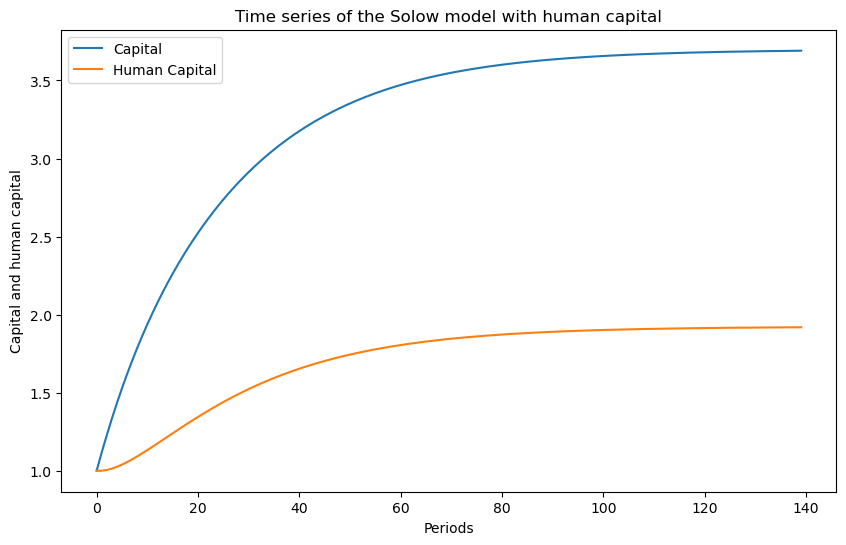

In [158]:
# Define parameters and time horizon
alpha = 1/3
delta = 0.1
phi = 1/3
s_K = 0.25
s_H = 0.13
n = 0.01
g = 0.02
k0 = 1
h0 = 1
T = 140

# Calculate time series
k, h = mp.capital(s_K, s_H, n, delta, alpha, phi, k0, h0, T, g)

# Plot time series
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(k, label='Capital')
ax.plot(h, label='Human Capital')
ax.set_xlabel('Periods')
ax.set_ylabel('Capital and human capital')
ax.set_title('Time series of the Solow model with human capital')
ax.legend()
plt.show()

I know test what happens with three different values for the savings rate for capital.

# Conclusion

Add concise conclusion. 